# Fase 3: Entrenamieto y Versionado de Modelos

In [23]:
import pandas as pd
import numpy as np
import os
from sklearn.linear_model import Ridge, Lasso
from sklearn.ensemble import RandomForestRegressor
from lightgbm import LGBMRegressor
from xgboost import XGBRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import json
from datetime import datetime
import hashlib
import joblib
from datetime import datetime

In [24]:
# carga de datos
X_train = pd.read_csv('../data/processed/X_train.csv')
X_test = pd.read_csv('../data/processed/X_test.csv')
y_train = pd.read_csv('../data/processed/y_train.csv').values.ravel()
y_test = pd.read_csv('../data/processed/y_test.csv').values.ravel()

print(f"X_train: {X_train.shape}")
print(f"X_test:  {X_test.shape}")
print(f"y_train: {y_train.shape}")
print(f"y_test:  {y_test.shape}")

X_train: (840, 30)
X_test:  (291, 30)
y_train: (840,)
y_test:  (291,)


### 3.1. Modelos

In [25]:
# Definición de modelos
models = {
    'Ridge': Ridge(alpha=1.0),
    'Lasso': Lasso(alpha=1.0),
    'RandomForest': RandomForestRegressor(n_estimators=300, random_state=42, n_jobs=-1, max_depth=10),
    'LightGBM': LGBMRegressor(n_estimators=100, random_state=42, n_jobs=-1),
    'XGBoost': XGBRegressor(n_estimators=100, random_state=42, n_jobs=-1)
}

print(f"Modelos definidos: {list(models.keys())}")

Modelos definidos: ['Ridge', 'Lasso', 'RandomForest', 'LightGBM', 'XGBoost']


In [26]:
# tracking de experimentos

os.makedirs('../results', exist_ok=True)
log_path = '../results/experiment_logs.csv'

def log_experiment(model_name, params, mae, rmse, r2):
    log_entry = {
        'model': model_name,
        'params': str(params),
        'mae': mae,
        'rmse': rmse,
        'r2': r2,
        'timestamp': datetime.now().isoformat()
    }
    
    # Append to CSV
    log_df = pd.DataFrame([log_entry])
    if os.path.exists(log_path):
        log_df.to_csv(log_path, mode='a', header=False, index=False)
    else:
        log_df.to_csv(log_path, index=False)
    
    print(f"  - MAE: {mae:,.1f} | RMSE: {rmse:,.1f} | R²: {r2:.3f}")

print(f"Logs en: {log_path}")

Logs en: ../results/experiment_logs.csv


In [27]:
# Entrenamiento y evaluación de modelos

results = []

for name, model in models.items():
    print(f"\nEntrenando {name}...")
    model.fit(X_train, y_train)
    pred = model.predict(X_test)
    
    mae = mean_absolute_error(y_test, pred)
    rmse = np.sqrt(mean_squared_error(y_test, pred))
    r2 = r2_score(y_test, pred)
    
    # Log
    log_experiment(name, model.get_params(), mae, rmse, r2)
    
    results.append({'model': name, 'mae': mae, 'rmse': rmse, 'r2': r2, 'model_obj': model})

# Convertir a DF
results_df = pd.DataFrame(results).sort_values('mae')
print("\nRESULTADOS:")
print(results_df[['model', 'mae', 'rmse', 'r2']].round(2))


Entrenando Ridge...
  - MAE: 2,765.5 | RMSE: 3,978.7 | R²: 0.488

Entrenando Lasso...
  - MAE: 2,631.1 | RMSE: 3,459.2 | R²: 0.613

Entrenando RandomForest...
  - MAE: 2,692.8 | RMSE: 3,558.9 | R²: 0.591

Entrenando LightGBM...
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000634 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 7465
[LightGBM] [Info] Number of data points in the train set: 840, number of used features: 30
[LightGBM] [Info] Start training from score 23627.410714
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
  - MAE: 2,863.5 | RMSE: 3,691.7 | R²: 0.559

Entrenando XGBoost...
  - MAE: 2,908.8 | RMSE: 3,764.8 | R²: 0.542

RESULTADOS:
          model      mae     rmse    r2
1         Lasso  2631.13  3459.

In [28]:
# Reentrenamiento final con el mejor modelo
from sklearn.linear_model import Lasso

# Mejor modelo: Lasso
final_model = Lasso(alpha=1.0)

# Unir train + test
X_full = pd.concat([X_train, X_test])
y_full = np.concatenate([y_train, y_test])

final_model.fit(X_full, y_full)
print("Modelo final reentrenado con todos los datos")

Modelo final reentrenado con todos los datos


In [29]:
# Guardar el modelo final

os.makedirs('../models', exist_ok=True)

version = "v1.0.0"
model_path = f'../models/modelo_{version}.pkl'
joblib.dump(final_model, model_path)

print(f"Modelo final guardado: {model_path}")

Modelo final guardado: ../models/modelo_v1.0.0.pkl


In [30]:
# Crear registro del modelo
registry = {
    "version": version,
    "model": "Lasso",
    "path": model_path,
    "mae_val": 2631.13,
    "rmse_val": 3459.15,
    "r2_val": 0.61,
    "alpha": 1.0,
    "train_date": datetime.now().isoformat(),
}

registry_path = '../models/model_registry.json'
with open(registry_path, 'w') as f:
    json.dump(registry, f, indent=2)

print(f"Registry creado: {registry_path}")

Registry creado: ../models/model_registry.json


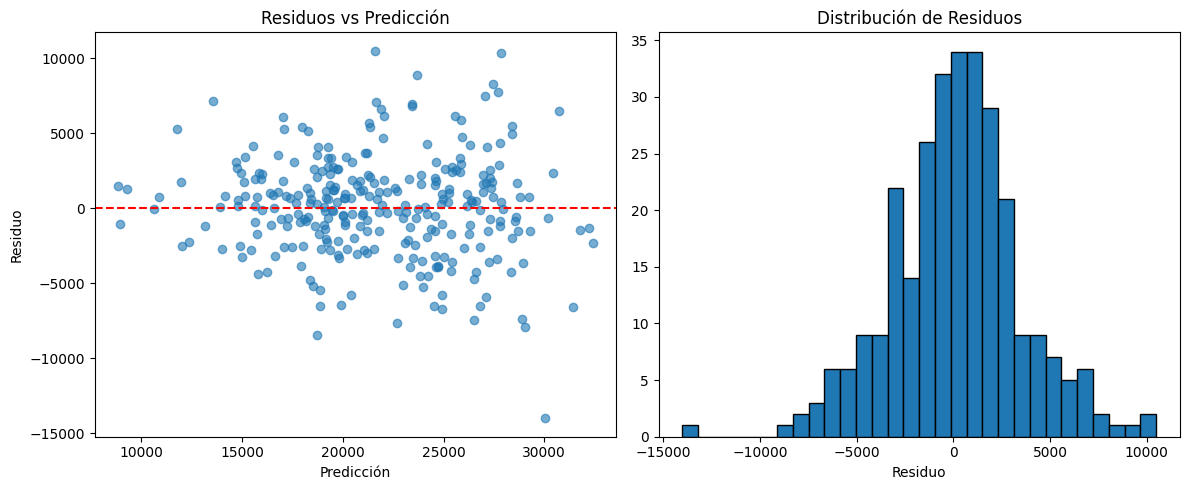

Top 10 coeficientes (Lasso):
rolling_7                                 4435.857361
Consolidado EE_Servicios (Kw)             2691.994370
rolling_30                                1839.520165
Totalizadores Energia_KW Linea 3          1502.229109
inter_agua_cond_x_frio                    1006.104143
Consolidado KPI_Aire Planta / Hl           338.658378
Consolidado KPI_EE Elaboracion / Hl        285.713712
Totalizadores Energia_KW Cond 5. 6 y 9     246.072387
Totalizadores Energia_KW Laboratorio       238.860519
Consolidado KPI_EE Frio / Hl               228.298367
dtype: float64


In [31]:
# Análisis de residuos y coeficientes
import matplotlib.pyplot as plt

pred = final_model.predict(X_test)
residuals = y_test - pred

plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.scatter(pred, residuals, alpha=0.6)
plt.axhline(0, color='red', linestyle='--')
plt.title('Residuos vs Predicción')
plt.xlabel('Predicción')
plt.ylabel('Residuo')

plt.subplot(1, 2, 2)
plt.hist(residuals, bins=30, edgecolor='black')
plt.title('Distribución de Residuos')
plt.xlabel('Residuo')
plt.tight_layout()
plt.show()

# Coeficientes
coefs = pd.Series(final_model.coef_, index=X_train.columns)
print("Top 10 coeficientes (Lasso):")
print(coefs.abs().sort_values(ascending=False).head(10))